In [186]:
import os
import torch
import numpy as np

from groundingdino.util.inference import load_model, load_image, predict, annotate
from groundingdino.util import box_ops
from segment_anything_hq import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

from PIL import Image

In [187]:
sam_checkpoint = "/scratch/gpfs/eh0560/segment-anything/sam_models/sam_hq_vit_h.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)

<All keys matched successfully>


In [188]:
images_dir = "/scratch/gpfs/RUSTOW/deskewing_datasets/images/cudl_images/images_25"
image_paths = [os.path.join(images_dir, path) for path in os.listdir(images_dir)]

In [189]:
dino_model = load_model("/scratch/gpfs/eh0560/GroundingDINO/groundingdino/config/GroundingDINO_SwinB_cfg.py", "/scratch/gpfs/eh0560/GroundingDINO/models/groundingdino_swinb_cogcoor.pth")
IMAGE_PATH = image_paths[17]
TEXT_PROMPT = "scanned document"
BOX_TRESHOLD = 0.45
TEXT_TRESHOLD = 0.25

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [190]:
image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=dino_model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[...,::-1]

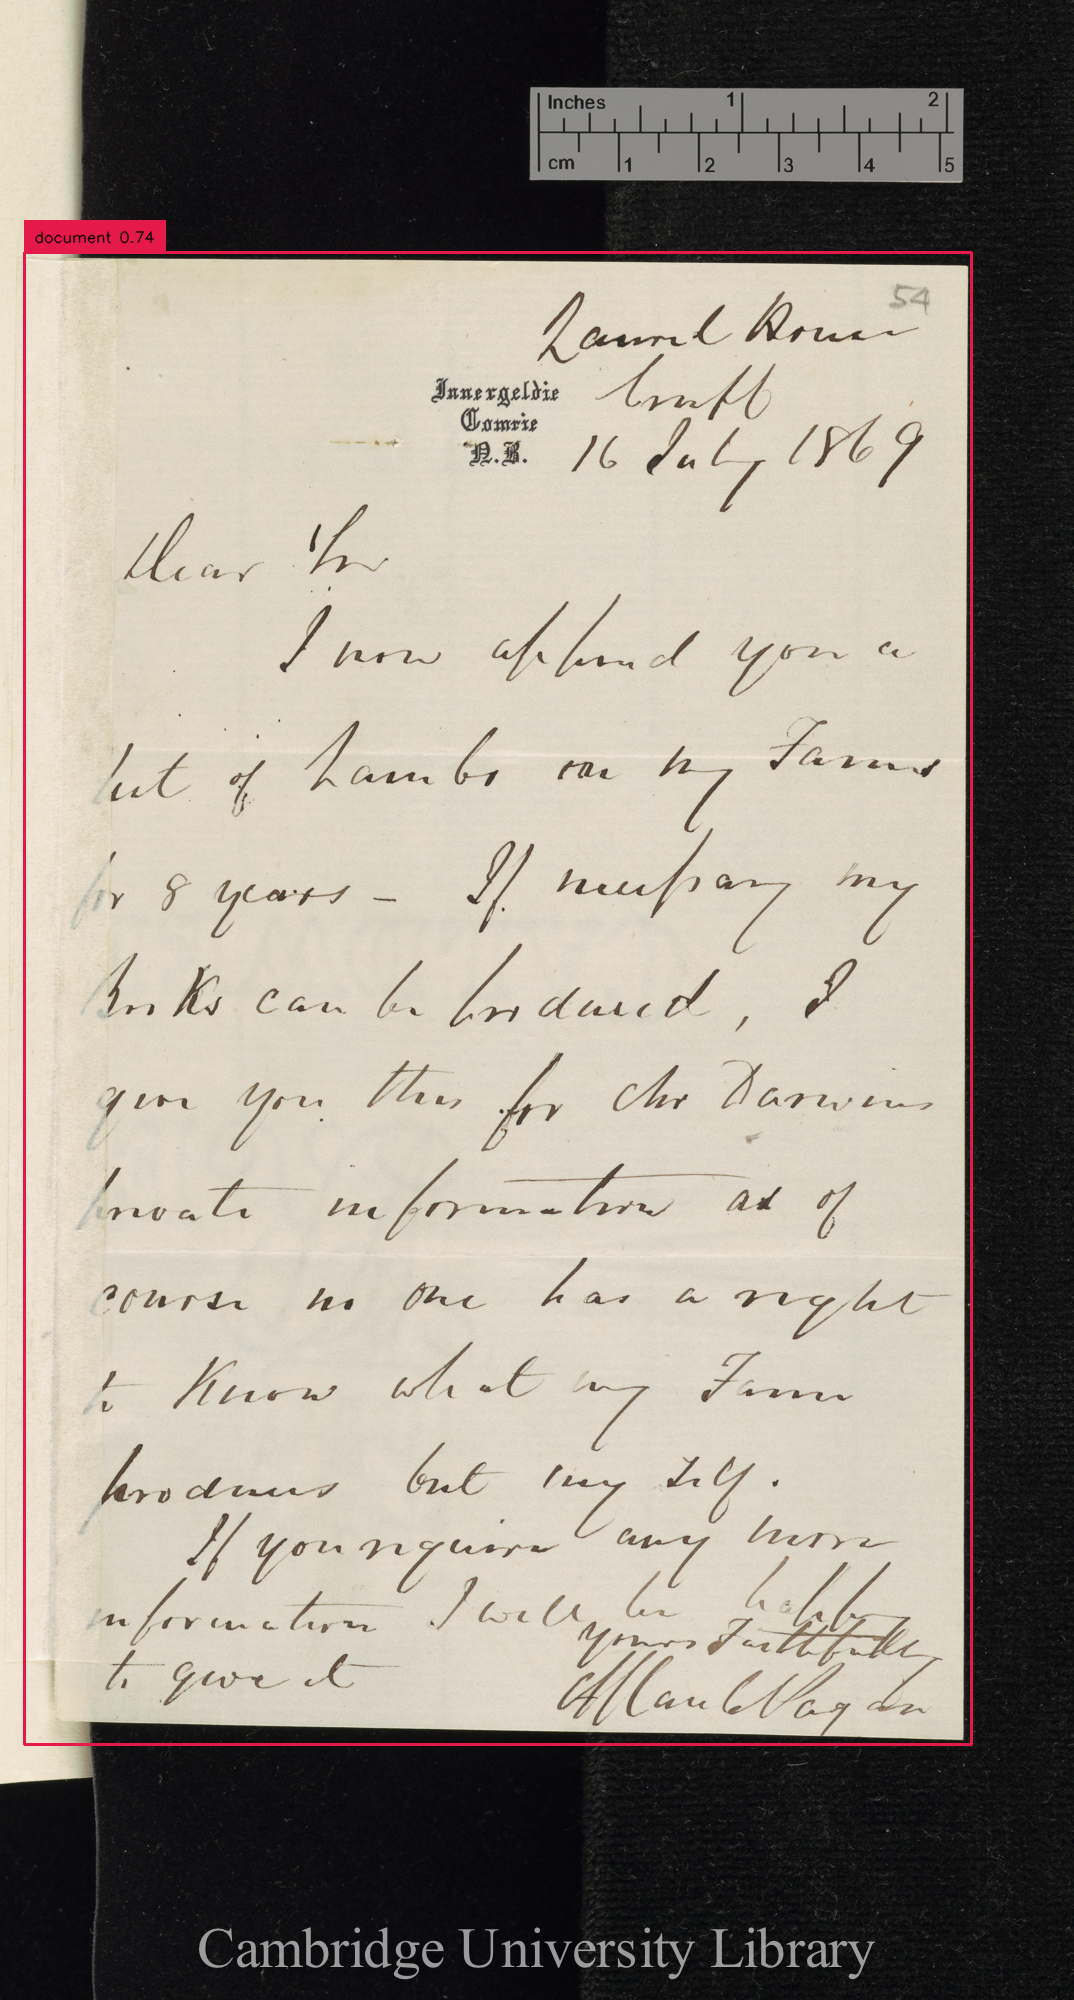

In [191]:
Image.fromarray(annotated_frame)

In [192]:
sam_predictor.set_image(image_source)

In [193]:
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

In [194]:
transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(device)
masks, _, _ = sam_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = transformed_boxes,
            multimask_output = False,
        )

In [195]:
def show_mask(mask, image, random_color=True):
    # Convert the mask tensor to the CPU if it's on CUDA
    if mask.is_cuda:
        mask = mask.cpu()
    
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])

    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))


In [196]:
annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)

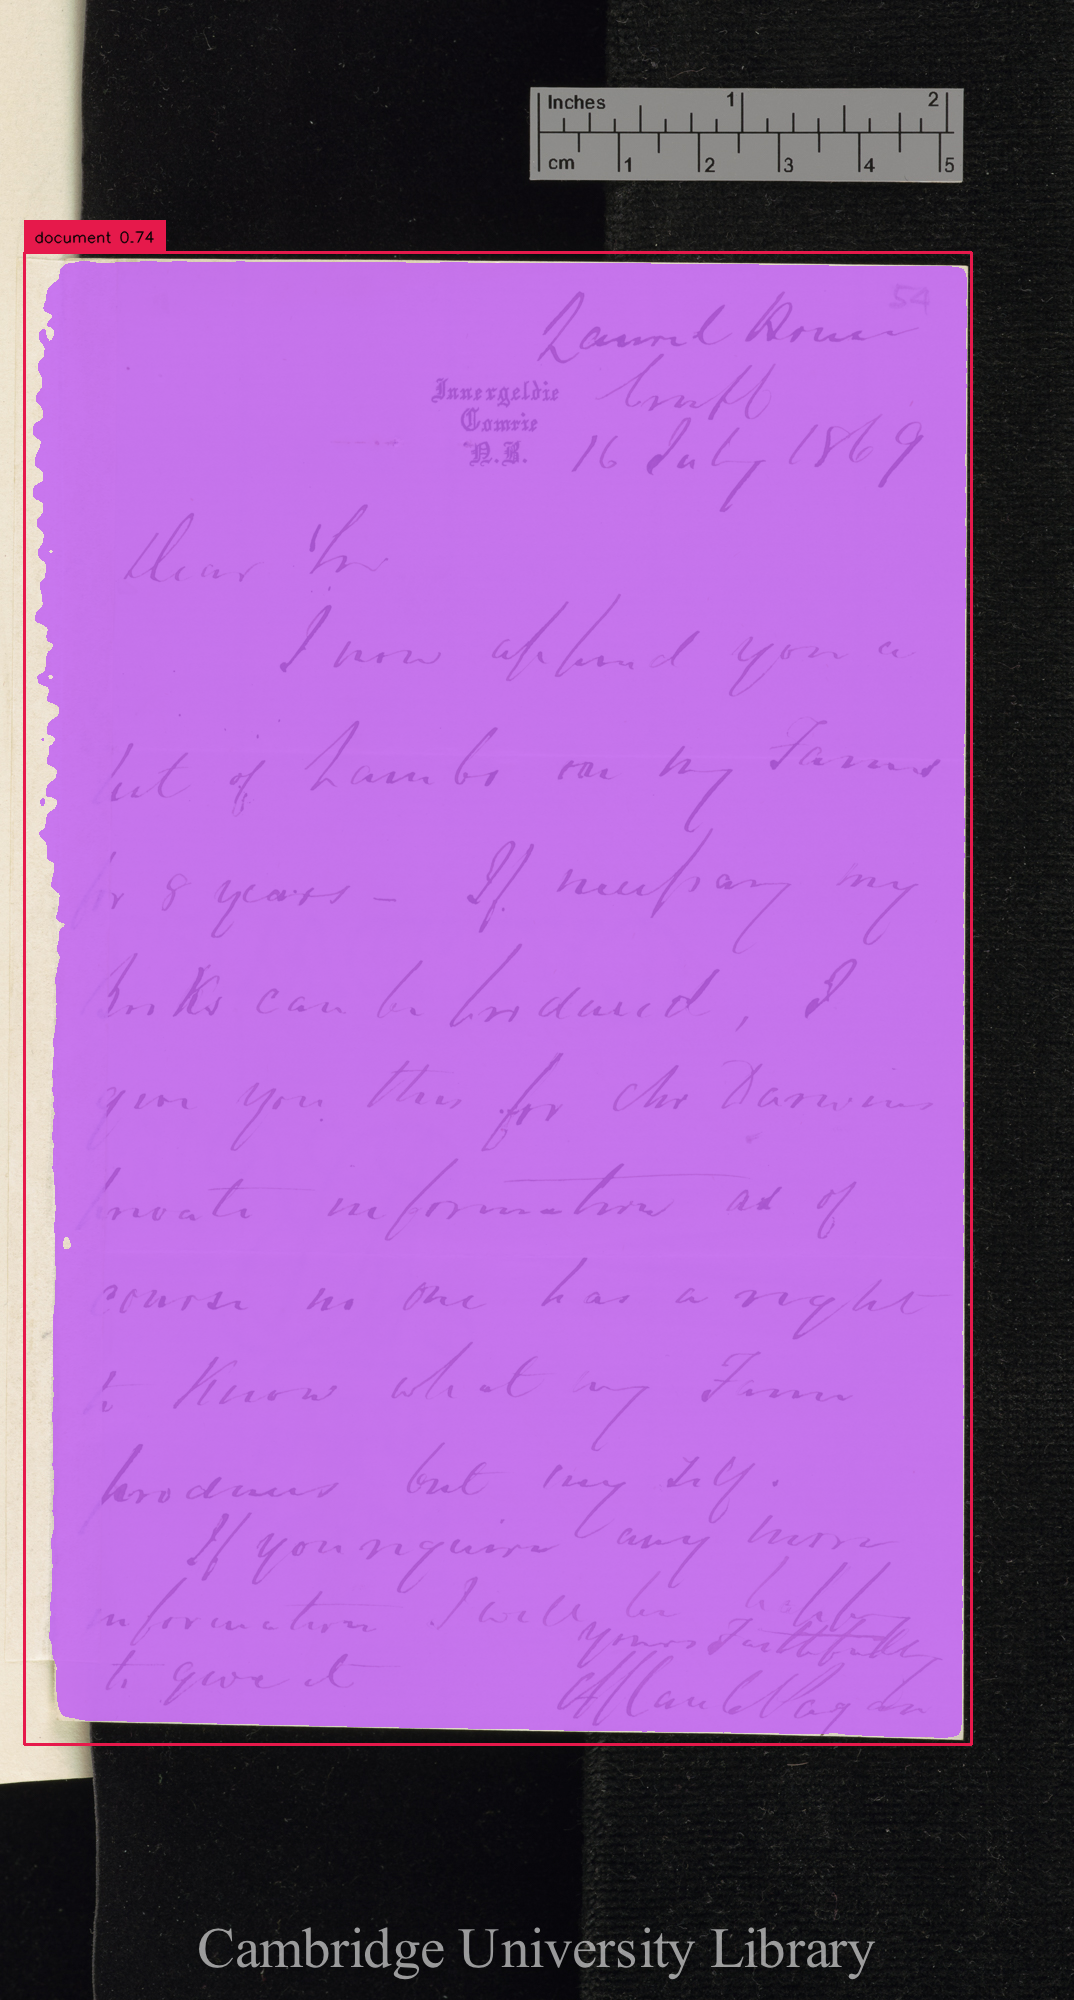

In [197]:
Image.fromarray(annotated_frame_with_mask)